# (3) Analyser notebook

This notebook is supposed to show how my implementation of the analysis of the sensor data works. My analysis relies on a Kalman-Filter applied to the position measurements which is convenient because it is able to smooth the data in real time. My implementation is a two-dimensional generalisation of the one-dimensional Wikipedia example at:
https://en.wikipedia.org/wiki/Kalman_filter#Example_application.2C_technical.

My `Analyser` class again derives from `threading.Thread`. It takes a queue as input and stores the result in a dictionary (`sensors`) which contains a list of results for each sensor ID that submits to the queue. It also takes a number of Kalman-Filter parameters, most notably:
* the initial position (`pos0`) and velocity (`vel0`) used in the filter
* and the error on the position measurement (`noise`).

I assumed that I know the initial position and velocity as well as the error on the position measurement, but the assumption could be relaxed by adapting the Kalman-Filter parameters.

Even after the data is Kalman-filtered, the estimator for the total distance covered is biased when I simply add up the distances between two consecutive points. This is because the distance between two noisy measurements has a complicated distribution (non-central chi-distribution) which is not centered around the true distance. The bias is worst when the athlete is not moving at all. To suppress this effect, I hence check at each point in time if the athlete is stationary, using an hypothesis test for the consistency of the estimated velocity with zero. Only if the athlete is not stationary, I add the distance to its previous position to the total distance covered.


## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [28]:
sns.set_context('notebook')

In [5]:
import numpy as np

In [6]:
from time import sleep

In [7]:
from Queue import Queue

In [8]:
from streamanalysis import Athlete, Sensor, Analyser

## Data generation

Here I first initialise the queue and instantiate the athlete. With the `keepdata` flag I ask the athlete to store its true positions in a list at `athlete.data`.

In [11]:
athlete = Athlete(keepdata=True, seed = 1)
ID = '0'
q = Queue()

I now run `sensor` and `analyser` for 5 minutes by starting both threads, then sleeping for 5 minutes, and finally stopping them. I also reset `athlete` so that it starts at its initial position. The `analyser` thread automatically stops after waiting for new queue entries for more than 1 second.

In [12]:
sensor = Sensor(athlete, q, ID, verbose = True)
analyser = Analyser(q)
athlete.reset()
# Start sensor and analyser
sensor.start()
analyser.start()
# Run sensor for 5 minutes
runtime = 60 * 5
sleep(runtime)
# Stop sensor
sensor.stop()

Sensor 0 started
Sensor 0 stopped


## Analysis of results

The results are stored as a `list` of `ResultSpec` instances in the `sensors` dictionary of the `analyser` instance. They can be accessed through the sensor ID. Each `ResultSpec` instance contains the filtered position (`pos`) and velocity (`vel`) with associated errors (`pos_err` and `vel_err`), the time stamp (`time`), the total distance (`dist`), and finally a flag that indicates whether or not the athlete-velocity is consistent with zero (`stat`).

In [13]:
# Get results for chosen ID from dictionary at sensors
results = analyser.sensors[ID]

In [14]:
# Compare number of filtered measurements to ellapsed time 
nres = len(results)
print 'Number of measurements:', nres
print 'Expected number of measurements', runtime * 20 + 1

Number of measurements: 6000
Expected number of measurements 6001


In [15]:
# Get time information from filtered measurements
delta_time = []
for i in range(nres-1):
    dt = results[i+1].time-results[i].time
    delta_time.append(dt.total_seconds())
ellapsed = np.append(0,np.cumsum(delta_time))/60.

In [17]:
# Extract data from results
# (I directly cast them to numpy array for more convenient plotting later)

# Position and error estimate
pos = []
pos_err = []

# Velocity and error estimate
vel = []
vel_err = []

# Estimate for total distance covered
dist = []

for r in results:
    pos.append(r.pos)
    pos_err.append(r.pos_err)
    vel.append(r.vel)
    vel_err.append(r.vel_err)
    dist.append(r.dist)
pos = np.asarray(pos)
pos_err = np.asarray(pos_err)
vel = np.asarray(vel)
vel_err = np.asarray(vel_err)
dist = np.asarray(dist)

The true data from `athlete` can be recovered from `athlete.data` (it's a list of `AthleteSpec` instances, i.e. a `namedtuple` containing position and velocity).

In [18]:
# Get true data from athlete (again as numpy arrays)
data = np.asarray(athlete.data)
true_pos = data[:,0]
true_vel = data[:,1]

In [19]:
# Calculate true total distance travelled
true_dist = np.append(0,np.cumsum(np.sqrt(((true_pos[1:] - true_pos[:-1])**2).sum(axis = 1))))

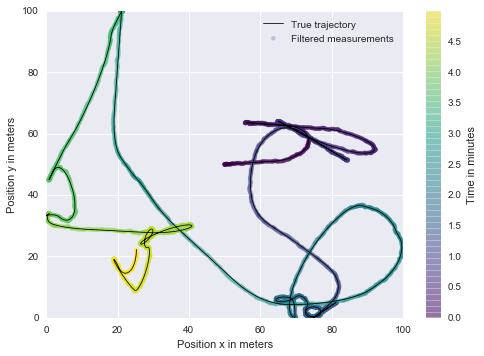

In [29]:
plt.scatter(pos[:,0], pos[:,1], c = ellapsed, alpha = .3, cmap = 'viridis',
            edgecolors='none', label = 'Filtered measurements')
plt.plot(true_pos[:,0],true_pos[:,1], color = 'k', label = 'True trajectory', lw = .8)
plt.legend(loc = 0)
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
_=plt.colorbar(label = 'Time in minutes')

This plot shows the filtered position data over 5 minutes, colour coded by the ellapsed time, together with the true trajectory of the athlete. Already visually the variance of the measurements around the true trajectory is suppressed compared to the figure in the sensor notebook.

In [30]:
# Estimate errors on position and velocity estimates by comparing them to true values
print 'Position error estimated from true data: ', (pos - true_pos).std()
print 'Position error estimated by Kalman-Filter: ', pos_err.mean()
print 'Velocity error estimated from true data: ', (vel - true_vel).std()
print 'Velocity error estimated by Kalman-Filter: ', vel_err.mean()

Position error estimated from true data:  0.139020021591
Position error estimated by Kalman-Filter:  0.142957084174
Velocity error estimated from true data:  0.446500705708
Velocity error estimated by Kalman-Filter:  0.538996846889


This is a comparison of the error of the filtered data, both estimated during the Kalman-filtering and by comparing the results to the real data. The accuracy of the positioning increased by a factor 2. The real benefit however is in the velocity estimate, where a naive estimate from the difference between the noisy, un-filtered positions would have an error of approximately $0.3\,m/0.05\,s \approx 6\,m /s$

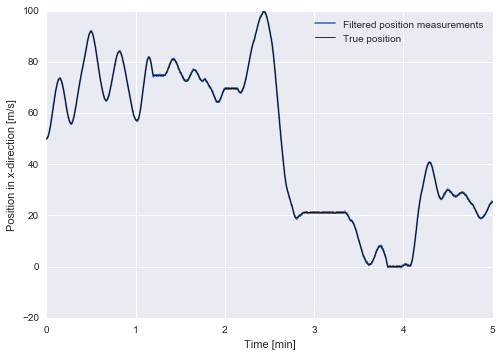

In [31]:
plt.plot(ellapsed, pos[:,0], label = 'Filtered position measurements')
plt.plot(ellapsed, true_pos[:,0], label = 'True position', color = 'k', lw = .8)
plt.xlim(0, runtime/60)
plt.ylabel('Position in x-direction [m/s]')
plt.xlabel('Time [min]')
plt.legend()

This plot shows the position of the athlete on the x-axis as inferred from the filtered data (blue) together with the true position (black) as a function of ellapsed time.

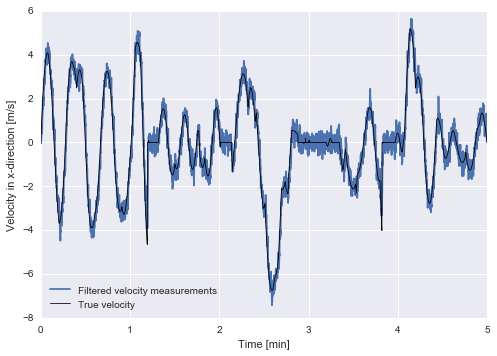

In [32]:
plt.plot(ellapsed, vel[:,0], label = 'Filtered velocity measurements')
plt.plot(ellapsed, true_vel[:,0], label = 'True velocity', color = 'k', lw = .8)
plt.xlim(0, runtime/60)
plt.ylabel('Velocity in x-direction [m/s]')
plt.xlabel('Time [min]')
plt.legend(loc = 0)

This plot shows a comparison of the filtered velocity (blue) and the true velocity (black)  along the x-axis as a function of ellapsed time.

In [25]:
# Calculate naive estimator for the total distance:
naive_dist = np.append(0,np.cumsum(np.sqrt(((pos[1:] - pos[:-1])**2).sum(axis = 1))))

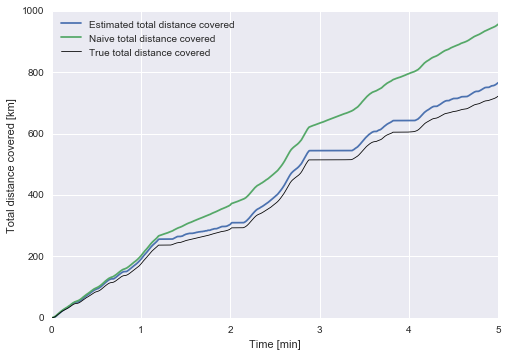

In [33]:
plt.plot(ellapsed, dist, label = 'Estimated total distance covered')
plt.plot(ellapsed, naive_dist, label = 'Naive total distance covered')
plt.plot(ellapsed, true_dist, label = 'True total distance covered', color = 'k', lw = .8)
plt.ylabel('Total distance covered [km]')
plt.xlabel('Time [min]')
plt.legend(loc = 0)

This plot shows a comparison of the true total distance covered by the athlete (black) with the distance estimated from naively adding up the distance between all filtered positions (green) and adding up the distance between those filtered positions where the velocity of the athlete is not consistent with zero (blue). While both estimators are biased to higher distances, the dominant contributions to the mismatch are coming from the stationary phases of the athlete. Hence, the blue line is much closer to the true distance than the green line.